In [210]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from scipy import io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


from tensorflow.keras import Model, Sequential, layers, optimizers, activations
from sklearn.feature_extraction.image import extract_patches_2d
import shutil


import numpy as np
from munkres import Munkres


class BaseAbundancesAligner:
    def __init__(self, hsi, criterion):
        self.Aref = hsi.A
        self.criterion = criterion
        self.P = None
        self.dists = None

    def fit(self, A):
        raise NotImplementedError

    def transform(self, A):
        assert self.P is not None, "Must be fitted first"
        assert A.shape[0] == self.P.shape[0]
        assert A.shape[0] == self.P.shape[1]

        return self.P @ A

    def transform_endmembers(self, E):
        assert self.P is not None, "Must be fitted first"
        assert E.shape[1] == self.P.shape[0]
        assert E.shape[1] == self.P.shape[1]

        return E @ self.P.T

    def fit_transform(self, A):

        self.fit(A)
        res = self.transform(A)
        return res

    def __repr__(self):
        msg = f"{self.__class__.__name__}_crit{self.criterion}"
        return msg


class Aligner(BaseAbundancesAligner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, A):

        # Computing distance matrix
        self.dists = self.criterion(A.T, self.Aref.T)

        # Initialization
        p = A.shape[0]
        P = np.zeros((p, p))

        m = Munkres()
        indices = m.compute(self.dists)
        for row, col in indices:
            P[row, col] = 1.0

        self.P = P.T

In [211]:

from metrics import MeanSquareError as MSE
from metrics import aRMSE as RMSE
from metrics import SADDegrees as SADMetric 

In [212]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

EPS = 1e-6


class HSI:
    def __init__(
        self,
        name: str,
        data_dir: str = "./Datasets/",
    ):
        path = os.path.join(data_dir, name)
        assert os.path.isfile(path)
        self.shortname = name.strip(".mat")

        data = sio.loadmat(path)
        print(f"Matlab data keys: {data.keys()}")

        for key in filter(
            lambda k: not k.startswith("__"),
            data.keys(),
        ):
            self.__setattr__(key, data[key])

        # Data format check
        self.H = self.H.item()
        self.W = self.W.item()
        self.L = self.L.item()
        self.p = self.p.item()
        

        self.N = self.H * self.W

        assert self.E.shape == (self.L, self.p)
        assert self.Y.shape == (self.L, self.N)

        # Data normalization
        self.Y = (self.Y - self.Y.min()) / (self.Y.max() - self.Y.min())

        try:
            assert len(self.labels) == self.p
            # Curate labels from MATLAB string formatting
            tmp_labels = list(self.labels)
            self.labels = [s.strip(" ") for s in tmp_labels]

        except AssertionError:
            # Create pseudo labels
            self.labels = [f"#{ii}" for ii in range(self.p)]

        assert self.A.shape == (self.p, self.N)
        # Abundance Sum to One Constraint (ASC)
        assert np.allclose(self.A.sum(0), np.ones(self.N))
        # Abundance Non-negative Constraint (ANC)
        assert np.all(self.A >= -EPS)
        # Endmembers Non-negative Constraint
        self.E = np.maximum(self.E, 0)
        assert np.all(self.E >= -EPS)

    def __repr__(self):
        msg = f"HSI => {self.shortname}\n"
        msg += "---------------------\n"
        msg += f"{self.L} bands,\n"
        msg += f"{self.H} lines, {self.W} samples, ({self.N} pixels),\n"
        msg += f"{self.p} endmembers ({self.labels})\n"
        msg += f"GlobalMinValue: {self.Y.min()}, GlobalMaxValue: {self.Y.max()}\n"
        return msg

    def __call__(self):
        Y = np.copy(self.Y)
        E = np.copy(self.E)
        A = np.copy(self.A)
        return (Y, E, A)

    def plot_endmembers(
        self,
        E0=None,
    ):
        """
        Display endmembers spectrum signature
        """
        # Plot attributes
        title = f"{self.shortname}"
        ylabel = "Reflectance"
        xlabel = "# Bands"
        if E0 is None:
            E = np.copy(self.E)
            title += " GT Endmembers\n"
            linestyle = "-"
        else:
            assert self.E.shape == E0.shape
            E = np.copy(E0)
            title += " Estimated Endmembers\n"
            linestyle = "--"
        # Figure
        plt.figure(figsize=(6, 6))
        
        for pp in range(self.p):
            print(self.p)
            data = E[:, pp]
            plt.plot(data, label=self.labels[pp], linestyle=linestyle)
        plt.title(title)
        plt.legend(frameon=True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_abundances(
        self,
        A0=None,
        transpose=False,
    ):
        """
        Display abundances maps
        """
        nrows, ncols = (1, self.p)
        title = f"{self.shortname}"
        if A0 is None:
            A = np.copy(self.A)
            title += " GT Abundances"
        else:
            assert self.A.shape == A0.shape
            A = np.copy(A0)
            title += " Estimated Abundances"
        A = A.reshape(self.p, self.H, self.W)

        if transpose:
            A = A.transpose(0, 2, 1)

        fig, ax = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(12, 4 * nrows),
        )
        kk = 0
        for ii in range(nrows):
            for jj in range(ncols):
                if nrows == 1:
                    curr_ax = ax[jj]
                else:
                    curr_ax = ax[ii, jj]
                mappable = curr_ax.imshow(
                    A[kk, :, :],
                    vmin=0.0,
                    vmax=1.0,
                )
                curr_ax.set_title(f"{self.labels[kk]}")
                curr_ax.axis("off")
                fig.colorbar(
                    mappable,
                    ax=curr_ax,
                    shrink=0.5,
                )
                kk += 1

                if kk == self.p:
                    break

        plt.suptitle(title)
        plt.show()

In [213]:
def training_input_fn(hsi, patch_size, patch_number, batch_size):
    patches = extract_patches_2d(hsi, (patch_size, patch_size), max_patches=patch_number)
    return patches

In [214]:
class SumToOne(tf.keras.layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
    def call(self, x):
        x = tf.nn.softmax(self.params['scale'] * x)
        return x

In [215]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction=10):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(self.filters // self.reduction, activation="relu")
        self.fc2 = tf.keras.layers.Dense(self.filters, activation="sigmoid")
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        x = self.pooling(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.keras.layers.Reshape((1, 1, self.filters))(x)
        x = inputs * x
        return x

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({"reduction": self.reduction})
        return config




class Encoder(tf.keras.Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer_one = tf.keras.layers.Conv2D(filters=self.params['e_filters'],
                                                       kernel_size=self.params['e_size'],
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=params['initializer'], use_bias=False)
        self.hidden_layer_two = tf.keras.layers.Conv2D(filters=self.params['num_endmembers'], kernel_size=1,
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        self.asc_layer = SumToOne(params=self.params, name='abundances')

    def call(self, input_patch):
        code = self.hidden_layer_one(input_patch)
        code = ChannelAttention()(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.hidden_layer_two(code)
        code = ChannelAttention()(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.asc_layer(code)
        return code

In [216]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.output_activation = tf.keras.layers.Lambda(lambda x: tf.nn.relu(x))
        self.output_layer = tf.keras.layers.Conv2D(filters=params['d_filters'], kernel_size=params['d_size'],
                                                   activation='linear',
                                                   kernel_constraint=tf.keras.constraints.non_neg(),
                                                   name='endmembers', strides=1, padding='same',
                                                   kernel_regularizer=None,
                                                   kernel_initializer=params['initializer'], use_bias=False)

    def call(self, code):
        recon = self.output_activation(code) 
        recon = self.output_layer(code)
        return recon

    def getEndmembers(self):
        return self.output_layer.get_weights()
    
    
    


In [217]:
class Autoencoder(tf.keras.Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.params = params

    def call(self, patch):
        abunds = self.encoder(patch)
        output = self.decoder(abunds)
        return output

    def getEndmembers(self):
        endmembers = self.decoder.getEndmembers()[0]
        if endmembers.shape[1] > 1:
            endmembers = np.squeeze(endmembers).mean(axis=0).mean(axis=0)
        else:
            endmembers = np.squeeze(endmembers)
        return endmembers

    def getAbundances(self, hsi):
        return np.squeeze(self.encoder.predict(np.expand_dims(hsi, 0)))

    def train(self, patches, callback):
        self.plotWhileTraining = callback
        self.fit(patches, patches, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                 callbacks=[self.plotWhileTraining], verbose=0)

    def saveResults(self, fname):
        endmembers = self.getEndmembers()
        abundances = self.getAbundances(params['data'])
        sads = self.plotWhileTraining.sads
        sio.savemat(fname, {'M': endmembers, 'A': abundances, 'sads': sads})

In [218]:
import scipy.io as sio




def numpy_SAD(y_true, y_pred):
    return np.arccos(y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred)))



In [219]:

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        
        gradients = tape.gradient(loss(model, original) + sum(model.losses), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)


def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    endmembers = tf.reshape(endmembers, [num_endmembers, -1])
    dict = {}
    sad_mat = np.ones((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(endmembers[i, :], endmembersGT[j, :])
    rows = 0
    while rows < num_endmembers:
        minimum = sad_mat.min()
        index_arr = np.where(sad_mat == minimum)
        if len(index_arr) < 2:
            break
        index = (index_arr[0][0], index_arr[1][0])
        if index[0] in dict.keys():
            sad_mat[index[0], index[1]] = 100
        elif index[1] in dict.values():
            sad_mat[index[0], index[1]] = 100
        else:
            dict[index[0]] = index[1]
            sad_mat[index[0], index[1]] = 100
            rows += 1
    ASAM = 0
    num = 0
    for i in range(num_endmembers):
        if np.var(endmembersGT[dict[i]]) > 0:
            ASAM = ASAM + numpy_SAD(endmembers[i, :], endmembersGT[dict[i]])
            num += 1

    return dict, ASAM / float(num)
  
def plotEndmembers(endmembers):
    endmembers = endmembers / endmembers.max()
    fig = plt.figure(1)
    for i in range(num_endmembers):
        ax = plt.subplot(2, 2, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plotEndmembersAndGT(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    n = num_endmembers // 2  # how many digits we will display
    if num_endmembers % 2 != 0: n = n + 1
    dict, sad = order_endmembers(endmembers, endmembersGT)

    fig = plt.figure(num=1, figsize=(8, 8))
    plt.clf()
    title = "aSAM score for all endmembers: " + format(sad, '.3f') + " radians"
    st = plt.suptitle(title)
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        plt.plot(endmembersGT[dict[i], :], 'k', linewidth=1.0)
        ax.set_title("SAD: " + str(i) + " :" + format(numpy_SAD(endmembers[i, :], endmembersGT[dict[i], :]), '.4f'))
        ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    plt.draw()
    plt.pause(0.001)
    
def plotAbundancesSimple(abundances):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    fig = plt.figure(2, figsize=[8, 8])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, i], cmap='viridis')
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im.set_clim([0, 1])
    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)


class PlotWhileTraining(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_n, hsi, gt):
        super(PlotWhileTraining, self).__init__()
        self.plot_every_n = plot_every_n
        num_endmembers = gt.shape[0]
        self.num_endmembers = num_endmembers
        self.input = hsi
        self.endmembersGT = gt
        self.sads = None

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_loss = []
        self.sads = []

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('SAD'))
        self.num_epochs = epoch
        print('*',end='')
        if self.plot_every_n == 0 or epoch % self.plot_every_n != 0:
            return
        plotEndmembersAndGT(self.endmembersGT, endmembers)
        abundances = self.model.getAbundances(self.input)
        plotAbundancesSimple(abundances)
        
        
      

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
HSI => TinyApex
---------------------
285 bands,
111 lines, 122 samples, (13542 pixels),
4 endmembers (['#0', '#1', '#2', '#3'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0

4
4
4
4


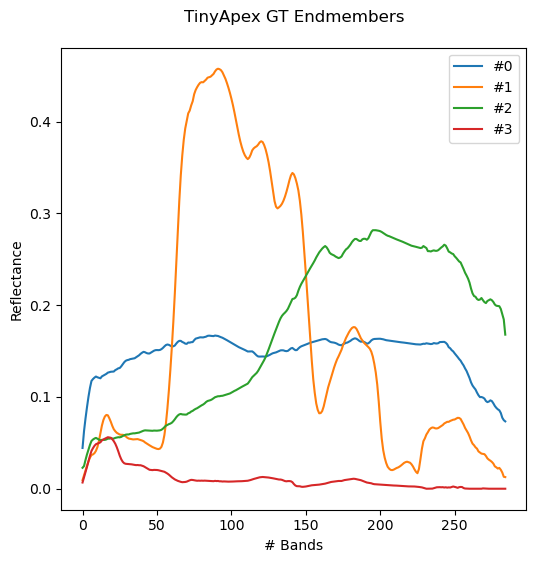

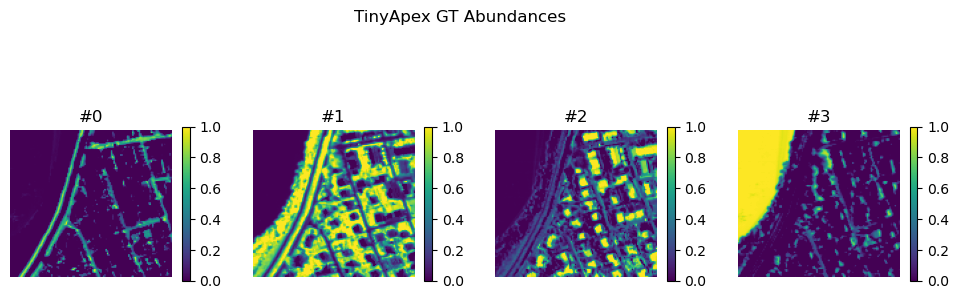

In [220]:
hsi = HSI("Apex.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()


In [221]:
n_bands = hsi.L
num_endmembers = hsi.p
patch_size = 40
num_patches = 250
batch_size = 15
learning_rate = 0.003
epochs = 100

scale = 3 
l2 = 0
l1 = 0e-8
tv = 0e-8

activation = tf.keras.layers.LeakyReLU(0.02)
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3)
regularizer = tf.keras.regularizers.l2(l2)

opt = tf.optimizers.RMSprop(learning_rate=learning_rate, decay=0.0)

dataset = hsi.shortname
data, GT, _ = hsi()

data = data.transpose()
data = data.reshape((hsi.H, hsi.W, hsi.L))

params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
          'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
          'initializer': initializer, 'l1': l1, 'tv': tv, 'patch_size': patch_size,
          'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}

In [222]:
num_runs = 1
plot_every_n = 0 
losses = []

for i in range(num_runs):
    print('Run number: '+str(i+1))

    patches = training_input_fn(data, patch_size, num_patches, batch_size)
    params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
              'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
              'initializer': initializer, 'patch_size': patch_size,
              'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}
    autoencoder = Autoencoder(params)

    
   
   


Run number: 1


In [223]:
import tensorflow as tf

def MCL(pred, target):

    eps = 1e-8
    pred = pred / tf.norm(pred, axis=-1, keepdims=True)
    target = target / tf.norm(target, axis=-1, keepdims=True)
    dot_product = tf.reduce_sum(pred * target, axis=-1)
    loss = 1 - tf.exp(dot_product)
    loss = tf.reduce_mean(loss, axis=-1)

    
    
    target = tf.reshape(target, [-1, 285])
    pred = tf.reshape(pred, [-1, 285])
    est_hist = tf.reduce_mean(tf.nn.softmax(pred, axis=1), axis=0)
    true_hist = tf.reduce_mean(tf.nn.softmax(target, axis=1), axis=0)

    joint_hist = tf.matmul(tf.reshape(est_hist, [-1, 1]), tf.reshape(true_hist, [1, -1]))

    est_entropy = -tf.reduce_sum(est_hist * tf.math.log(est_hist + eps))
    true_entropy = -tf.reduce_sum(true_hist * tf.math.log(true_hist + eps))

    joint_entropy = -tf.reduce_sum(joint_hist * tf.math.log(joint_hist + eps))

    mutual_info = est_entropy + true_entropy - joint_entropy
    
    
    return loss + 0.1*mutual_info



    

In [224]:
autoencoder.compile(opt, loss=MCL)
autoencoder.train(callback=PlotWhileTraining(plot_every_n, data, GT), patches=patches, )
endmembers = autoencoder.getEndmembers()
abundances = autoencoder.getAbundances(data)


****************************************************************************************************

C:\Users\Nithish Reddy\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


4
4
4
4


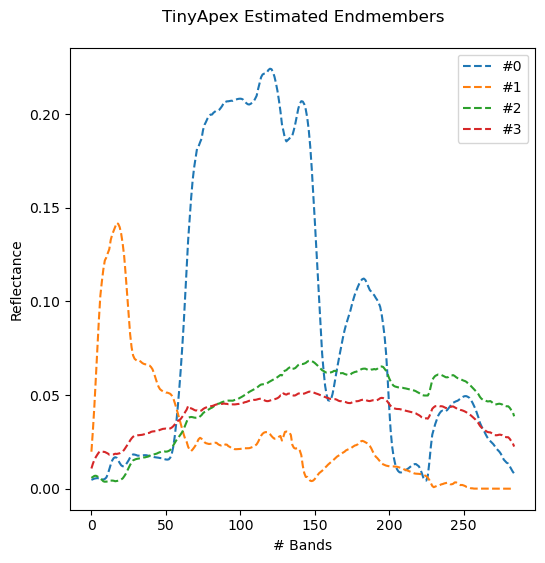

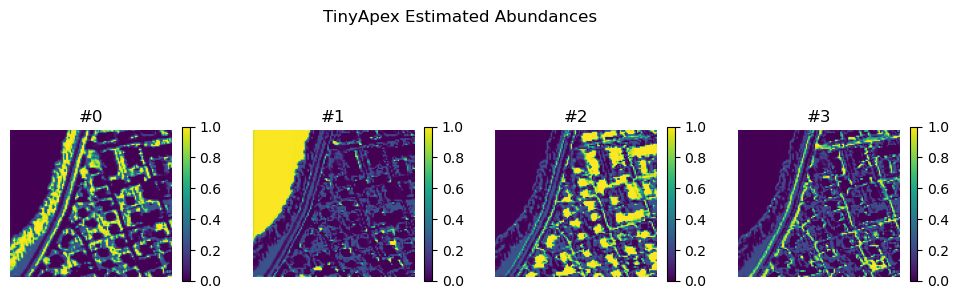

In [225]:
E0 = endmembers.T
A0 = abundances.transpose(2, 0, 1).reshape(hsi.p, hsi.N)

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

4
4
4
4


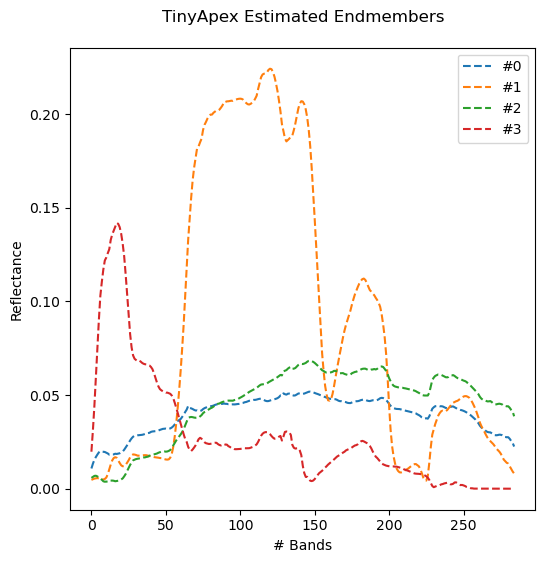

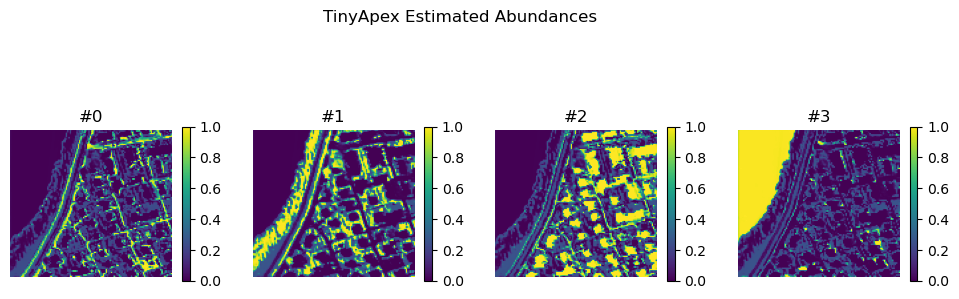

In [226]:
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

In [227]:

rmse = RMSE()
sad = SADMetric()

print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")

RMSE => 25.67
SAD => 8.84


In [228]:
hsi.labels = ["Road", "Tree", "Roof", "water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")


RMSE (Road) => 26.90
RMSE (Tree) => 30.55
RMSE (Roof) => 23.78
RMSE (water) => 20.32
---------------
SAD (Road) => 9.20
SAD (Tree) => 8.79
SAD (Roof) => 15.07
SAD (water) => 2.28
